In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from matplotlib.lines import Line2D
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
dataframe = pd.read_csv('/content/sensorDataWithAnamoly.csv')
df = dataframe[['Time', 'SensorVal']]
# df['Time'] = pd.to_datetime(df['Time'])

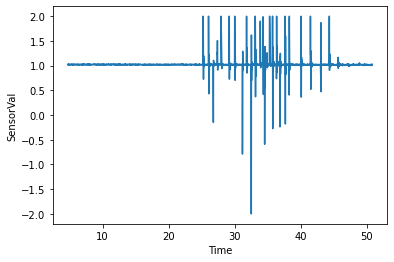

In [ ]:
sns.lineplot(x=df['Time'], y=df['SensorVal'])


In [ ]:
print("start time: ", df['Time'].min())
print("end time: ", df['Time'].max())

start time:  4.734
end time:  50.81399999999999


In [ ]:
# training and testing data split
train, test = df.loc[df['Time'] <= 38.649], df.loc[df['Time'] > 38.649]

In [ ]:
test

,Time,SensorVal
1705,38.668,1.031006
1706,38.687,1.011963
1707,38.706,1.019287
1708,38.725,1.025146
1709,38.744,1.030029
...,...,...
2269,50.734,1.011475
2270,50.754,1.018799
2271,50.774,1.004883
2272,50.794,1.015137


# Standard scaler:
#many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected

---



---



---



In [ ]:
# Normalizing done to standardize the data -- (x-mu)/(sigma)
scaler = StandardScaler()
scaler = scaler.fit(train[['SensorVal']])

In [ ]:
train['SensorVal'] = scaler.transform(train[['SensorVal']])
test['SensorVal'] = scaler.transform(test[['SensorVal']])

In [ ]:
# https://stackoverflow.com/questions/54235845/what-exactly-is-timestep-in-an-lstm-model (for LSTM time steps)

In [ ]:
seq_size = 30 # Number of time steps 


In [ ]:
# x is sequence, y is what comes next in sequence
def to_sequences(x, y, seq_size = 1):
  x_values = []
  y_values =[]
  for i in range(len(x)-seq_size):
    x_values.append(x.iloc[i:(i+seq_size)].values)
    y_values.append(y.iloc[i+seq_size])
  return np.array(x_values), np.array(y_values)


In [ ]:
trainX, trainY = to_sequences(train[['SensorVal']], train['SensorVal'], seq_size)
testX, testY = to_sequences(test[['SensorVal']], test['SensorVal'], seq_size)

In [ ]:
# https://stackoverflow.com/questions/45278286/how-to-choose-lstm-keras-parameters
# https://stackoverflow.com/questions/10200268/what-does-shape-do-in-for-i-in-rangey-shape0/21200291
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(trainX.shape[1]))
model.add(TimeDistributed((Dense(trainX.shape[2]))))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model fit
history = model.fit(trainX, trainY, epochs=60, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/60
48/48 [==============================] - 1s 31ms/step - loss: 0.1319 - val_loss: 0.6395
Epoch 2/60
48/48 [==============================] - 1s 30ms/step - loss: 0.1307 - val_loss: 0.6414
Epoch 3/60
48/48 [==============================] - 1s 31ms/step - loss: 0.1293 - val_loss: 0.6406
Epoch 4/60
48/48 [==============================] - 1s 30ms/step - loss: 0.1303 - val_loss: 0.6453
Epoch 5/60
48/48 [==============================] - 1s 31ms/step - loss: 0.1288 - val_loss: 0.6565
Epoch 6/60
48/48 [==============================] - 1s 31ms/step - loss: 0.1287 - val_loss: 0.6583
Epoch 7/60
48/48 [==============================] - 1s 30ms/step - loss: 0.1304 - val_loss: 0.6524
Epoch 8/60
48/48 [==============================] - 1s 30ms/step - loss: 0.1299 - val_loss: 0.6479
Epoch 9/60
48/48 [==============================] - 1s 31ms/step - loss: 0.1291 - val_loss: 0.6416
Epoch 10/60
48/48 [==============================] - 1s 30ms/step - loss: 0.1288 - val_loss: 0.6461
Epoch 11/

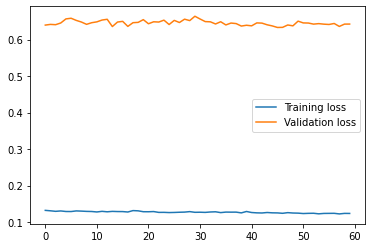

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label= 'Validation loss')
plt.legend()

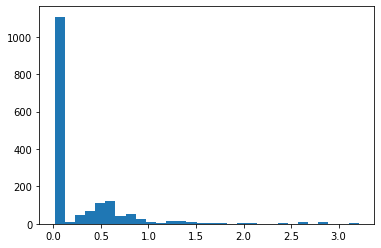

In [ ]:
# Anamoly is where reconstruction error is large
# value can be defined, beyond which it is called anamoly
# MAE - mean absolue error is calculated
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis =1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 1.25 # max threshold 

(array([387.,  25.,   4.,   5.,  49.,  51.,   2.,   2.,   3.,   2.,   1.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([0.01606234, 0.10946994, 0.20287755, 0.29628516, 0.38969276,
        0.48310037, 0.57650798, 0.66991558, 0.76332319, 0.8567308 ,
        0.9501384 , 1.04354601, 1.13695362, 1.23036122, 1.32376883,
        1.41717644, 1.51058404, 1.60399165, 1.69739926, 1.79080686,
        1.88421447, 1.97762207, 2.07102968, 2.16443729, 2.25784489,
        2.3512525 , 2.44466011, 2.53806771, 2.63147532, 2.72488293,
        2.81829053]),
 <a list of 30 Patch objects>)

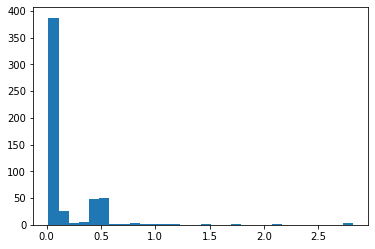

In [ ]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [ ]:
#DataFrame
anamoly_df = pd.DataFrame(test[seq_size:])
anamoly_df['testMAE'] = testMAE
anamoly_df['max_trainMAE'] = max_trainMAE
anamoly_df['anamoly'] = anamoly_df['testMAE'] > anamoly_df['max_trainMAE']
anamoly_df['SensorVal'] = test[seq_size:]['SensorVal']

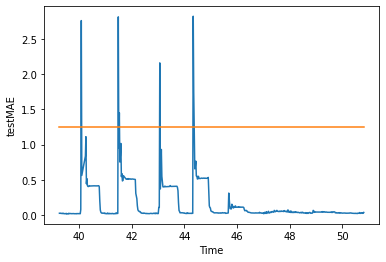

In [ ]:
# plot testMAE vs max_trainMAE
sns.lineplot(x=anamoly_df['Time'], y=anamoly_df['testMAE'])
sns.lineplot(x=anamoly_df['Time'], y=anamoly_df['max_trainMAE'])

In [ ]:
anomalies = anamoly_df.loc[anamoly_df['anamoly'] == True]

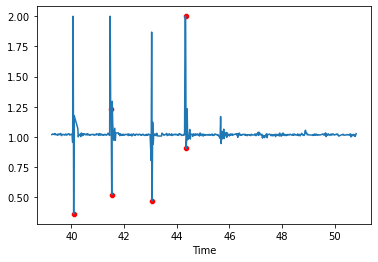

In [ ]:
# plotting anamoly
sns.lineplot(x=anamoly_df['Time'], y=scaler.inverse_transform(anamoly_df['SensorVal']))
sns.scatterplot(x=anomalies['Time'], y=scaler.inverse_transform(anomalies['SensorVal']), color='r')

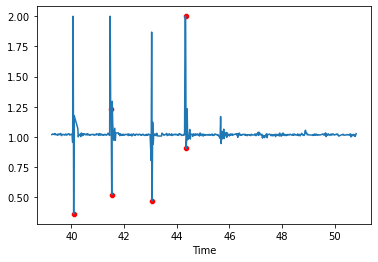

In [ ]:
# plotting anamoly
sns.lineplot(x=anamoly_df['Time'], y=scaler.inverse_transform(anamoly_df['SensorVal']))
sns.scatterplot(x=anomalies['Time'], y=scaler.inverse_transform(anomalies['SensorVal']), color='r')